# 연수구, 남동구 Subset 비교

In [1]:
import os
from typing import List

import geopandas as gpd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from metr.dataset.interpolator import (Interpolator,
                                       IterativeRandomForestInterpolator,
                                       LinearInterpolator, SplineInterpolator,
                                       TimeMeanFillInterpolator)
from metr.dataset.metr_imc.converter.graph_sensor_locations import \
    SensorNetworkView
from metr.dataset.metr_imc.generator import MetrImcSubsetGenerator
from scipy import stats
from tqdm import tqdm

os.makedirs("./output/subset-all/", exist_ok=True)

## 연수구 and 남동구 Node 추출

데이터와 그래프 구조가 비교적 안정적으로 보이는 연수구와 남동구의 노드만 추출

In [2]:
yn_selected_roads: gpd.GeoDataFrame = gpd.read_file(
    "../datasets/metr-imc/subsets/metr-imc-268/selected_road.shp"
)
yn_selected_roads

,index,sensor_id,geometry
0,71,1650026001,POINT (126.7067 37.39807)
1,73,1650042800,POINT (126.73509 37.42093)
2,127,1650074500,POINT (126.71392 37.40455)
3,129,1650232500,POINT (126.73677 37.40341)
4,131,1650388801,POINT (126.69317 37.40302)
...,...,...,...
556,16293,1650037302,POINT (126.72667 37.41513)
557,16301,1650002302,POINT (126.71535 37.39645)
558,16311,1650231700,POINT (126.73463 37.40239)
559,16319,1640011900,POINT (126.67742 37.40453)


In [3]:
yn_selected_roads.explore(color="red", legend=True)

In [4]:
target_road_list = yn_selected_roads["sensor_id"].tolist()
print(target_road_list)

['1650026001', '1650042800', '1650074500', '1650232500', '1650388801', '1650395901', '1650381201', '1640050304', '1640012500', '1640015100', '1640015200', '1630007900', '1640242500', '1650381701', '1640017100', '1650362401', '1650374901', '1640320400', '1650027500', '1650073200', '1640042400', '1640012600', '1650353301', '1640050203', '1640000200', '1640325901', '1640042500', '1650037200', '1650042700', '1650031401', '1640247400', '1640016700', '1640025600', '1640330401', '1640051200', '1640246800', '1640244500', '1640014100', '1650369001', '1640245500', '1640050204', '1640014900', '1650072801', '1630012100', '1640016000', '1640016101', '1650368301', '1650230800', '1610195803', '1650374101', '1640046900', '1650031002', '1650073000', '1650045502', '1640245800', '1650028501', '1650380201', '1640044701', '1640020001', '1630057400', '1640033900', '1650072702', '1640021900', '1640029400', '1630008000', '1640046302', '1650035001', '1650390201', '1650000600', '1650381101', '1650032300', '1640

In [5]:
traffic_raw: pd.DataFrame = pd.read_hdf("../datasets/metr-imc/metr-imc.h5")
traffic_raw.head()

,1663134300,1690003802,1650230200,1650083103,1660021100,1650012200,1670019300,1680254605,1650230800,1660035502,...,1670013605,1610050500,1663193601,1690012602,1660003801,1660000901,1640018500,1610090000,1670031105,1660001801
2023-01-26 00:00:00,0.0,NaN,0.0,0.0,23.0,0.0,0.0,6.0,0.0,12.0,...,0.0,0.0,0.0,NaN,251.0,0.0,0.0,0.0,NaN,0.0
2023-01-26 01:00:00,0.0,NaN,0.0,0.0,24.0,0.0,0.0,6.0,0.0,6.0,...,0.0,0.0,0.0,NaN,205.0,0.0,0.0,0.0,NaN,0.0
2023-01-26 02:00:00,0.0,NaN,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,169.0,0.0,0.0,0.0,NaN,0.0
2023-01-26 03:00:00,0.0,NaN,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,119.0,0.0,0.0,0.0,NaN,0.0
2023-01-26 04:00:00,0.0,NaN,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,176.0,0.0,0.0,0.0,NaN,0.0


In [6]:
traffic_data = traffic_raw[target_road_list]
traffic_data_output_path = "./output/subset-all/traffic_data_raw.xlsx"
traffic_data.head()

,1650026001,1650042800,1650074500,1650232500,1650388801,1650395901,1650381201,1640050304,1640012500,1640015100,...,1630011803,1640013902,1650352801,1650043801,1640244000,1650037302,1650002302,1650231700,1640011900,1650090702
2023-01-26 00:00:00,35.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,76.0,0.0
2023-01-26 01:00:00,34.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,44.0,0.0
2023-01-26 02:00:00,33.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,34.0,0.0
2023-01-26 03:00:00,32.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,33.0,0.0
2023-01-26 04:00:00,62.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,58.0,0.0


### Index 정렬 확인

In [7]:
index_sorted = pd.date_range(start=traffic_data.index.min(), end=traffic_data.index.max(), freq='h')
print(index_sorted == traffic_data.index)
print("Index Sorted: ", traffic_data.index.is_monotonic_increasing)

if not traffic_data.index.is_monotonic_increasing:
    print("Sorting Index...")
    traffic_data = traffic_data.sort_index()

print("Index Sorted: ", traffic_data.index.is_monotonic_increasing)
traffic_data = traffic_data.asfreq("h")
traffic_data.index

[False False False ... False False False]
Index Sorted:  False
Sorting Index...
Index Sorted:  True


DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2024-03-01 14:00:00', '2024-03-01 15:00:00',
               '2024-03-01 16:00:00', '2024-03-01 17:00:00',
               '2024-03-01 18:00:00', '2024-03-01 19:00:00',
               '2024-03-01 20:00:00', '2024-03-01 21:00:00',
               '2024-03-01 22:00:00', '2024-03-01 23:00:00'],
              dtype='datetime64[ns]', length=10224, freq='h')

### 기간 지정

In [8]:
start_date = pd.to_datetime("2023-03-01")
end_date = pd.to_datetime("2024-02-29 23:00:00")
traffic_data = traffic_data.loc[start_date:end_date]
traffic_data

,1650026001,1650042800,1650074500,1650232500,1650388801,1650395901,1650381201,1640050304,1640012500,1640015100,...,1630011803,1640013902,1650352801,1650043801,1640244000,1650037302,1650002302,1650231700,1640011900,1650090702
2023-03-01 00:00:00,7.0,0.0,0.0,NaN,69.0,6.0,0.0,NaN,0.0,10.0,...,48.0,34.0,NaN,15.0,23.0,60.0,NaN,NaN,103.0,55.0
2023-03-01 01:00:00,14.0,9.0,0.0,NaN,38.0,3.0,0.0,NaN,0.0,14.0,...,14.0,16.0,NaN,0.0,20.0,35.0,NaN,NaN,110.0,38.0
2023-03-01 02:00:00,9.0,0.0,0.0,NaN,45.0,0.0,0.0,NaN,0.0,14.0,...,25.0,11.0,NaN,5.0,3.0,30.0,NaN,NaN,78.0,27.0
2023-03-01 03:00:00,0.0,3.0,0.0,NaN,28.0,0.0,0.0,NaN,0.0,0.0,...,29.0,12.0,NaN,0.0,7.0,6.0,NaN,NaN,27.0,13.0
2023-03-01 04:00:00,19.0,0.0,0.0,NaN,27.0,0.0,0.0,NaN,0.0,0.0,...,14.0,3.0,NaN,4.0,5.0,3.0,NaN,NaN,66.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 19:00:00,329.0,142.0,NaN,97.0,281.0,151.0,28.0,430.0,7.0,23.0,...,237.0,179.0,129.0,52.0,139.0,148.0,NaN,NaN,182.0,138.0
2024-02-29 20:00:00,296.0,119.0,NaN,91.0,232.0,109.0,37.0,427.0,0.0,26.0,...,142.0,127.0,80.0,55.0,74.0,152.0,NaN,NaN,144.0,124.0
2024-02-29 21:00:00,224.0,92.0,NaN,79.0,153.0,114.0,6.0,330.0,0.0,25.0,...,121.0,89.0,63.0,28.0,45.0,113.0,NaN,NaN,120.0,119.0
2024-02-29 22:00:00,90.0,34.0,NaN,12.0,52.0,22.0,0.0,95.0,0.0,6.0,...,30.0,15.0,0.0,14.0,16.0,28.0,NaN,NaN,44.0,20.0


In [9]:
if not os.path.exists(traffic_data_output_path):
    traffic_data.to_excel("./output/subset-all/traffic_data_raw.xlsx")

## 결측치 및 이상치

### 결측치 및 이상치 기준

1. 데이터 없음
2. 데이터 없는 값 주변 0값
    - 데이터 없는 값 주변의 0값들의 시간대에서 대부분 0이 아닌 경우가 많음
3. Z-Score 기준 99.9999999%

### 결측치 제거

In [10]:
# 2번 항목
def extend_nans_around_zeros(series: pd.Series) -> pd.Series:
    series = series.copy()
    nan_indices = series[series.isna()].index

    for idx in nan_indices:
        idx_pos = series.index.get_loc(idx)

        i = idx_pos - 1
        while i >= 0 and series.iat[i] == 0:
            series.iat[i] = np.nan
            i -= 1

        i = idx_pos + 1
        while i < len(series) and series.iat[i] == 0:
            series.iat[i] = np.nan
            i += 1

    return series

traffic_data_01az = traffic_data.apply(extend_nans_around_zeros)
traffic_data_01az_output_path = "./output/subset-all/traffic_data_01az.xlsx"
traffic_data_01az.head()

,1650026001,1650042800,1650074500,1650232500,1650388801,1650395901,1650381201,1640050304,1640012500,1640015100,...,1630011803,1640013902,1650352801,1650043801,1640244000,1650037302,1650002302,1650231700,1640011900,1650090702
2023-03-01 00:00:00,7.0,0.0,0.0,NaN,69.0,6.0,0.0,NaN,0.0,10.0,...,48.0,34.0,NaN,15.0,23.0,60.0,NaN,NaN,103.0,55.0
2023-03-01 01:00:00,14.0,9.0,0.0,NaN,38.0,3.0,0.0,NaN,0.0,14.0,...,14.0,16.0,NaN,0.0,20.0,35.0,NaN,NaN,110.0,38.0
2023-03-01 02:00:00,9.0,0.0,0.0,NaN,45.0,0.0,0.0,NaN,0.0,14.0,...,25.0,11.0,NaN,5.0,3.0,30.0,NaN,NaN,78.0,27.0
2023-03-01 03:00:00,0.0,3.0,0.0,NaN,28.0,0.0,0.0,NaN,0.0,0.0,...,29.0,12.0,NaN,0.0,7.0,6.0,NaN,NaN,27.0,13.0
2023-03-01 04:00:00,19.0,0.0,0.0,NaN,27.0,0.0,0.0,NaN,0.0,0.0,...,14.0,3.0,NaN,4.0,5.0,3.0,NaN,NaN,66.0,26.0


In [11]:
if not os.path.exists(traffic_data_01az_output_path):
    traffic_data_01az.to_excel("./output/subset-all/traffic_data_01az.xlsx")

### 이상치 제거

In [12]:
# 사용 안 함
def detect_outliers_iqr(df: pd.DataFrame) -> pd.DataFrame:
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df < lower_bound) | (df > upper_bound)

    return outliers, {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound
    }

def detect_outliers_zscore_series(df: pd.DataFrame, threshold=3) -> pd.DataFrame:
    # 시간대 별로 데이터를 그룹화하여 z-score 계산
    outliers = pd.DataFrame(index=df.index, columns=df.columns)
    
    info = []
    for hour in range(24):
        hourly_data = df[df.index.hour == hour]
        z_scores = np.abs(stats.zscore(hourly_data, nan_policy='omit'))
        outliers.loc[hourly_data.index] = z_scores > threshold
        info.append({
            "hour": hour
        })
    
    return outliers, info

def detect_outliers_zscore_df(df: pd.DataFrame, threshold=3) -> pd.DataFrame:
    # 시간대 별로 데이터를 그룹화하여 z-score 계산
    outliers = pd.DataFrame(index=df.index, columns=df.columns, dtype=bool)
    
    info = []
    for hour in range(24):
        hourly_data: pd.DataFrame = df[df.index.hour == hour]

        mean = hourly_data.stack().mean()  # 시간대별 모든 값의 평균
        std = hourly_data.stack().std()  # 시간대별 모든 값의 표준편차
        z_scores = (hourly_data - mean) / std

        outliers.loc[hourly_data.index] = np.abs(z_scores) > threshold
        info.append({
            "hour": hour,
            "mean": mean,
            "std": std,
            "threshold": threshold,
            "outlier_threshold": mean + threshold * std
        })

    outliers = outliers.convert_dtypes()
    dtypes = outliers.dtypes.unique()
    if len(dtypes) > 1:
        print("Warning: Different data types detected in the outlier dataframe.")
    return outliers, info

quantile_outliers, quantile_outlier_info = detect_outliers_iqr(traffic_data_01az)
zscore_outliers, zscore_outlier_info = detect_outliers_zscore_df(traffic_data_01az, threshold=15)

In [13]:
zscore_outliers.dtypes.unique()

array([BooleanDtype], dtype=object)

In [14]:
for info in zscore_outlier_info:
    print(info)

{'hour': 0, 'mean': 37.352062, 'std': 578.0423, 'threshold': 15, 'outlier_threshold': 8707.98652267456}
{'hour': 1, 'mean': 93.16484, 'std': 5603.3745, 'threshold': 15, 'outlier_threshold': 84143.78251647949}
{'hour': 2, 'mean': 132.33972, 'std': 7273.189, 'threshold': 15, 'outlier_threshold': 109230.17419433594}
{'hour': 3, 'mean': 147.36073, 'std': 8040.965, 'threshold': 15, 'outlier_threshold': 120761.83338928223}
{'hour': 4, 'mean': 162.483, 'std': 8321.877, 'threshold': 15, 'outlier_threshold': 124990.63729858398}
{'hour': 5, 'mean': 127.19157, 'std': 2997.0088, 'threshold': 15, 'outlier_threshold': 45082.323402404785}
{'hour': 6, 'mean': 189.84155, 'std': 1587.5138, 'threshold': 15, 'outlier_threshold': 24002.548461914062}
{'hour': 7, 'mean': 257.56937, 'std': 891.09955, 'threshold': 15, 'outlier_threshold': 13624.062591552734}
{'hour': 8, 'mean': 291.9276, 'std': 690.5848, 'threshold': 15, 'outlier_threshold': 10650.699279785156}
{'hour': 9, 'mean': 243.56992, 'std': 541.2119, '

In [15]:
def get_missing_and_outliers(df: pd.DataFrame, outlier_df: pd.DataFrame, target: str, start_date=None, end_date=None):
    start_date = pd.to_datetime(start_date) if start_date is not None else None
    end_date = pd.to_datetime(end_date) if end_date is not None else None
    series = df[target]
    if start_date is not None and end_date is not None:
        series = series.loc[start_date:end_date]
    elif start_date is not None:
        series = series.loc[start_date:]
    elif end_date is not None:
        series = series.loc[:end_date]

    missing_values: pd.Series = series[~series.notna()]
    outliers: pd.Series = series[outlier_df[target]]

    return outliers, missing_values

def plot_column_with_outliers(
    df: pd.DataFrame, outlier_df: pd.DataFrame, target: str, start_date=None, end_date=None
):
    start_date = pd.to_datetime(start_date) if start_date is not None else None
    end_date = pd.to_datetime(end_date) if end_date is not None else None
    series = df[target]
    if start_date is not None and end_date is not None:
        series = series.loc[start_date:end_date]
    elif start_date is not None:
        series = series.loc[start_date:]
    elif end_date is not None:
        series = series.loc[:end_date]

    missing_values: pd.Series = series[~series.notna()].fillna(-10)
    outliers: pd.Series = series[outlier_df[target]]

    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label="Normal Data", color="black")
    plt.scatter(outliers.index, outliers, label="Outliers", color="red")
    plt.scatter(missing_values.index, missing_values, label="Missing Values", color="orange")

    plt.title(f"Sensor ID: {target}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
target_col_cursor = -1

82 / 561
Outliers: 
2023-09-08 22:00:00    3487.0
Freq: h, Name: 1640049000, dtype: float32


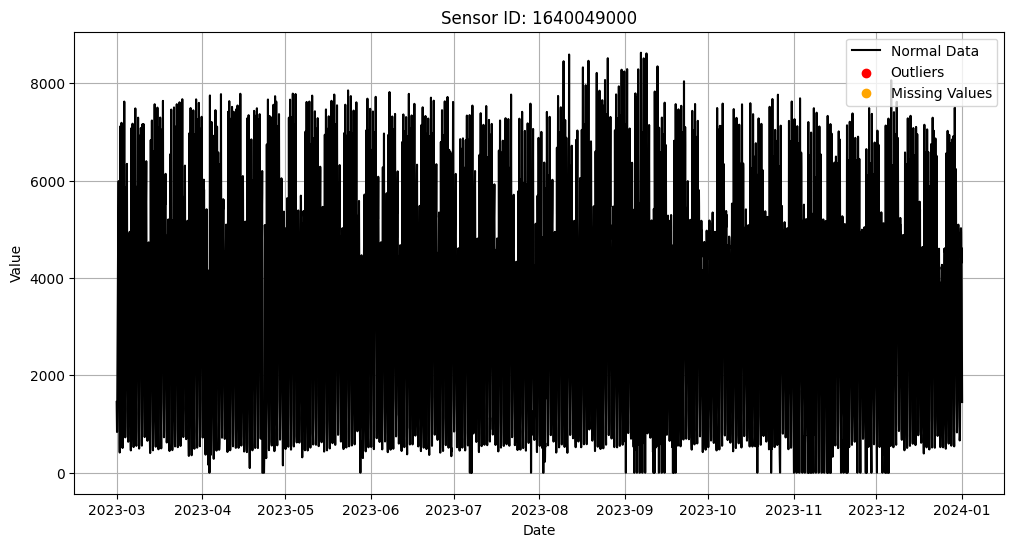

In [17]:
while target_col_cursor < len(traffic_data_01az.columns) - 1:
    target_col_cursor += 1
    target_column = traffic_data_01az.columns[target_col_cursor]
    start_date = "2023-01-01"
    end_date = "2024-01-01"

    outliers, missing_values = get_missing_and_outliers(traffic_data_01az, zscore_outliers, target_column, start_date, end_date)
    if len(outliers) != 0:
        print(target_col_cursor, "/", len(traffic_data_01az.columns))
        print("Outliers: ")
        print(outliers)
        plot_column_with_outliers(traffic_data_01az, zscore_outliers, target_column, start_date, end_date)
        break

In [18]:
traffic_data_cleaned = traffic_data_01az.mask(zscore_outliers)
traffic_data_cleaned

,1650026001,1650042800,1650074500,1650232500,1650388801,1650395901,1650381201,1640050304,1640012500,1640015100,...,1630011803,1640013902,1650352801,1650043801,1640244000,1650037302,1650002302,1650231700,1640011900,1650090702
2023-03-01 00:00:00,7.0,0.0,0.0,NaN,69.0,6.0,0.0,NaN,0.0,10.0,...,48.0,34.0,NaN,15.0,23.0,60.0,NaN,NaN,103.0,55.0
2023-03-01 01:00:00,14.0,9.0,0.0,NaN,38.0,3.0,0.0,NaN,0.0,14.0,...,14.0,16.0,NaN,0.0,20.0,35.0,NaN,NaN,110.0,38.0
2023-03-01 02:00:00,9.0,0.0,0.0,NaN,45.0,0.0,0.0,NaN,0.0,14.0,...,25.0,11.0,NaN,5.0,3.0,30.0,NaN,NaN,78.0,27.0
2023-03-01 03:00:00,0.0,3.0,0.0,NaN,28.0,0.0,0.0,NaN,0.0,0.0,...,29.0,12.0,NaN,0.0,7.0,6.0,NaN,NaN,27.0,13.0
2023-03-01 04:00:00,19.0,0.0,0.0,NaN,27.0,0.0,0.0,NaN,0.0,0.0,...,14.0,3.0,NaN,4.0,5.0,3.0,NaN,NaN,66.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 19:00:00,329.0,142.0,NaN,97.0,281.0,151.0,28.0,430.0,7.0,23.0,...,237.0,179.0,129.0,52.0,139.0,148.0,NaN,NaN,182.0,138.0
2024-02-29 20:00:00,296.0,119.0,NaN,91.0,232.0,109.0,37.0,427.0,0.0,26.0,...,142.0,127.0,80.0,55.0,74.0,152.0,NaN,NaN,144.0,124.0
2024-02-29 21:00:00,224.0,92.0,NaN,79.0,153.0,114.0,6.0,330.0,0.0,25.0,...,121.0,89.0,63.0,28.0,45.0,113.0,NaN,NaN,120.0,119.0
2024-02-29 22:00:00,90.0,34.0,NaN,12.0,52.0,22.0,0.0,95.0,0.0,6.0,...,30.0,15.0,0.0,14.0,16.0,28.0,NaN,NaN,44.0,20.0


In [19]:
CLEAN_DATA_OUTPUT_PATH = "./output/subset-all/traffic_data_cleaned.xlsx"

if not os.path.exists(CLEAN_DATA_OUTPUT_PATH):
    traffic_data_cleaned.to_excel(CLEAN_DATA_OUTPUT_PATH)

### Issue

- 이상치 기준을 어떻게 잡을 것인가?
    - 전체 데이터의 z-score를 사용하기엔 너무 들쭉날쭉하다
    - 한 열의 z-score를 사용하면 이상치가 없어 보이는 열에서도 무조건 이상치로 분류되는 데이터가 있다.
- 결측치의 기준
    - NaN 데이터 그리고 NaN 주변 0 데이터를 결측치 처리하는 것 외에 다른 결측치는 없는가?

## Subset 생성 전략

1. 대상 노드 및 기간 전체
2. 대상 노드에서 결측치 500개 미만
3. 대상 노드에서 2~4월 데이터만
4. 대상 노드에서 결측치 500개 미만 및 2~4월 데이터만

In [20]:
def visualize_missing_matrix(df: pd.DataFrame):
    msno.matrix(df)
    plt.show()

def visualize_missing_heatmap(df: pd.DataFrame):
    msno.heatmap(df, labels=False)
    plt.show()

def visualize_missing_bar(df: pd.DataFrame):
    msno.bar(df)
    plt.show()

def visualize_missingno(df: pd.DataFrame):
    visualize_missing_matrix(df)
    visualize_missing_heatmap(df)
    visualize_missing_bar(df)

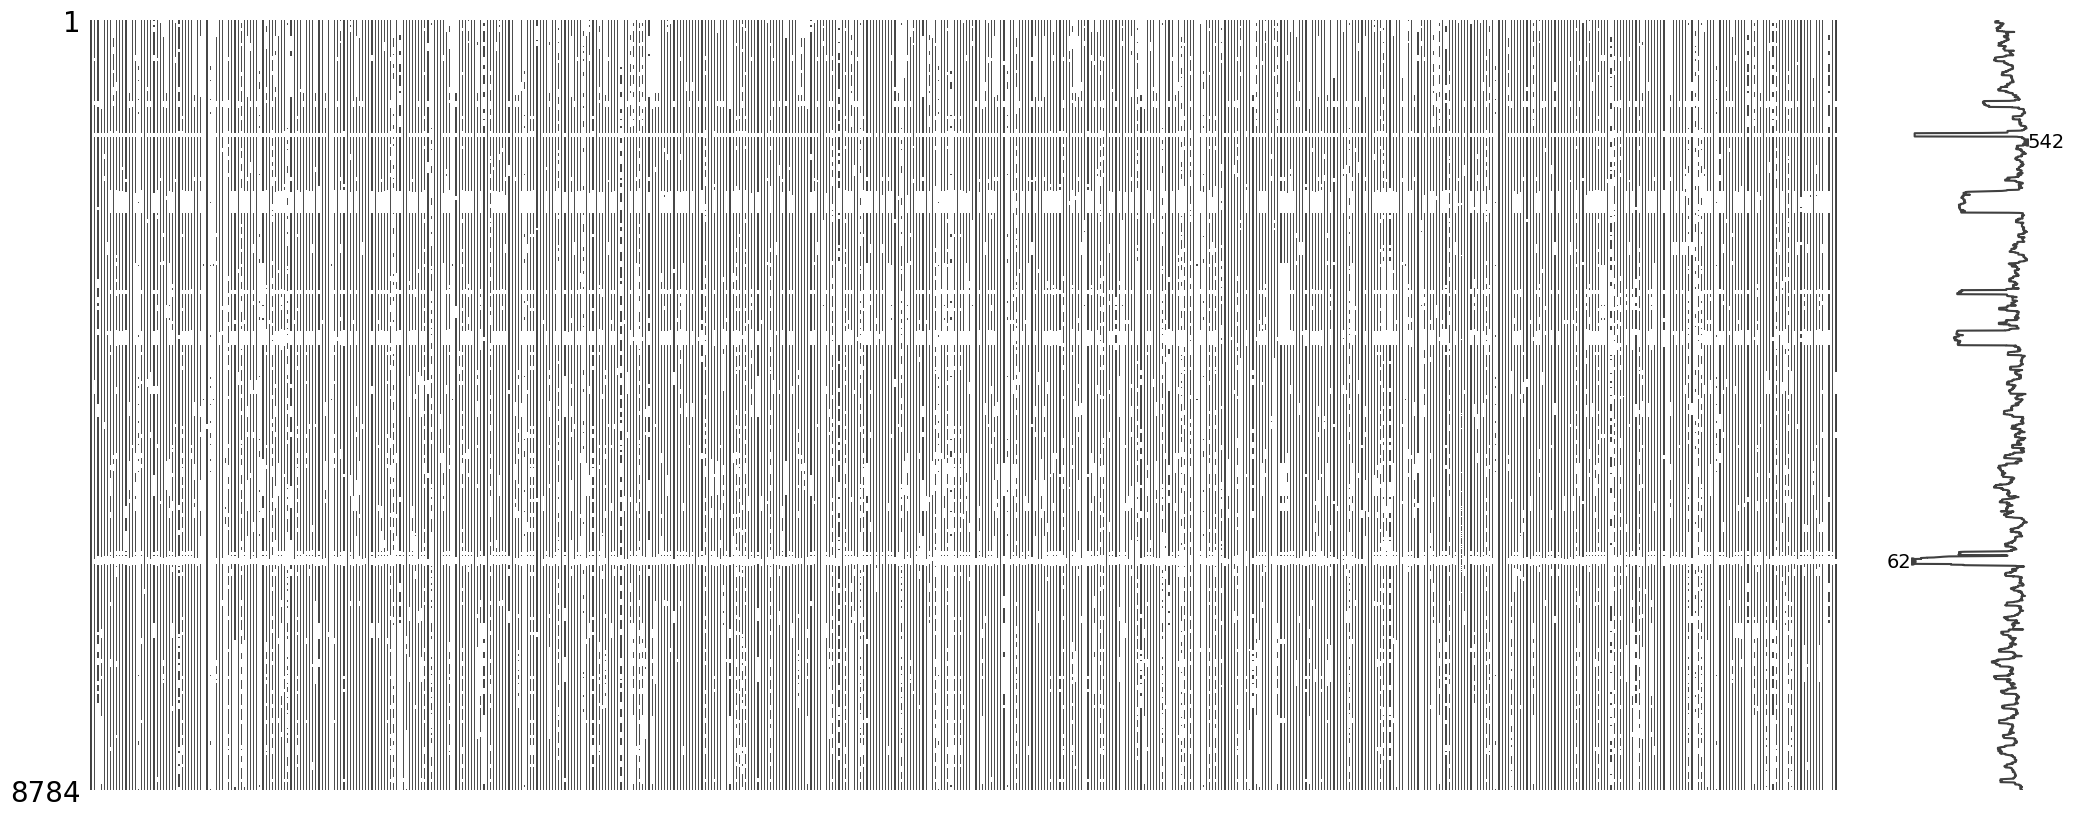

In [21]:
visualize_missing_matrix(traffic_data_cleaned)

In [22]:
# 1 모든 데이터가 결측치인 열을 제외
traffic_data_cleaned_no_nan = traffic_data_cleaned.dropna(axis=1, how='all')

# 2 노드 수 줄이기
traffic_data_cleaned_less500 = traffic_data_cleaned_no_nan.loc[:, traffic_data_cleaned_no_nan.isnull().sum() < 500]

# 3 기간 제한
traffic_data_cleaned_short_term = traffic_data_cleaned_no_nan.loc["2023-11-16":"2024-02-29"].dropna(axis=1, how='all')
# 다음 열에서 문제가 발생하므로 해당 열을 제외
not_valid_cols = ['1630012100', '1640245800', '1640245000', '1640243800', '1640244400', '1640244200']
traffic_data_cleaned_short_term = traffic_data_cleaned_short_term.drop(columns=not_valid_cols)

# 4 노드 수 줄이기 및 기간 제한
traffic_data_cleaned_combined = traffic_data_cleaned_short_term.loc[:, traffic_data_cleaned_short_term.isnull().sum() < 500]

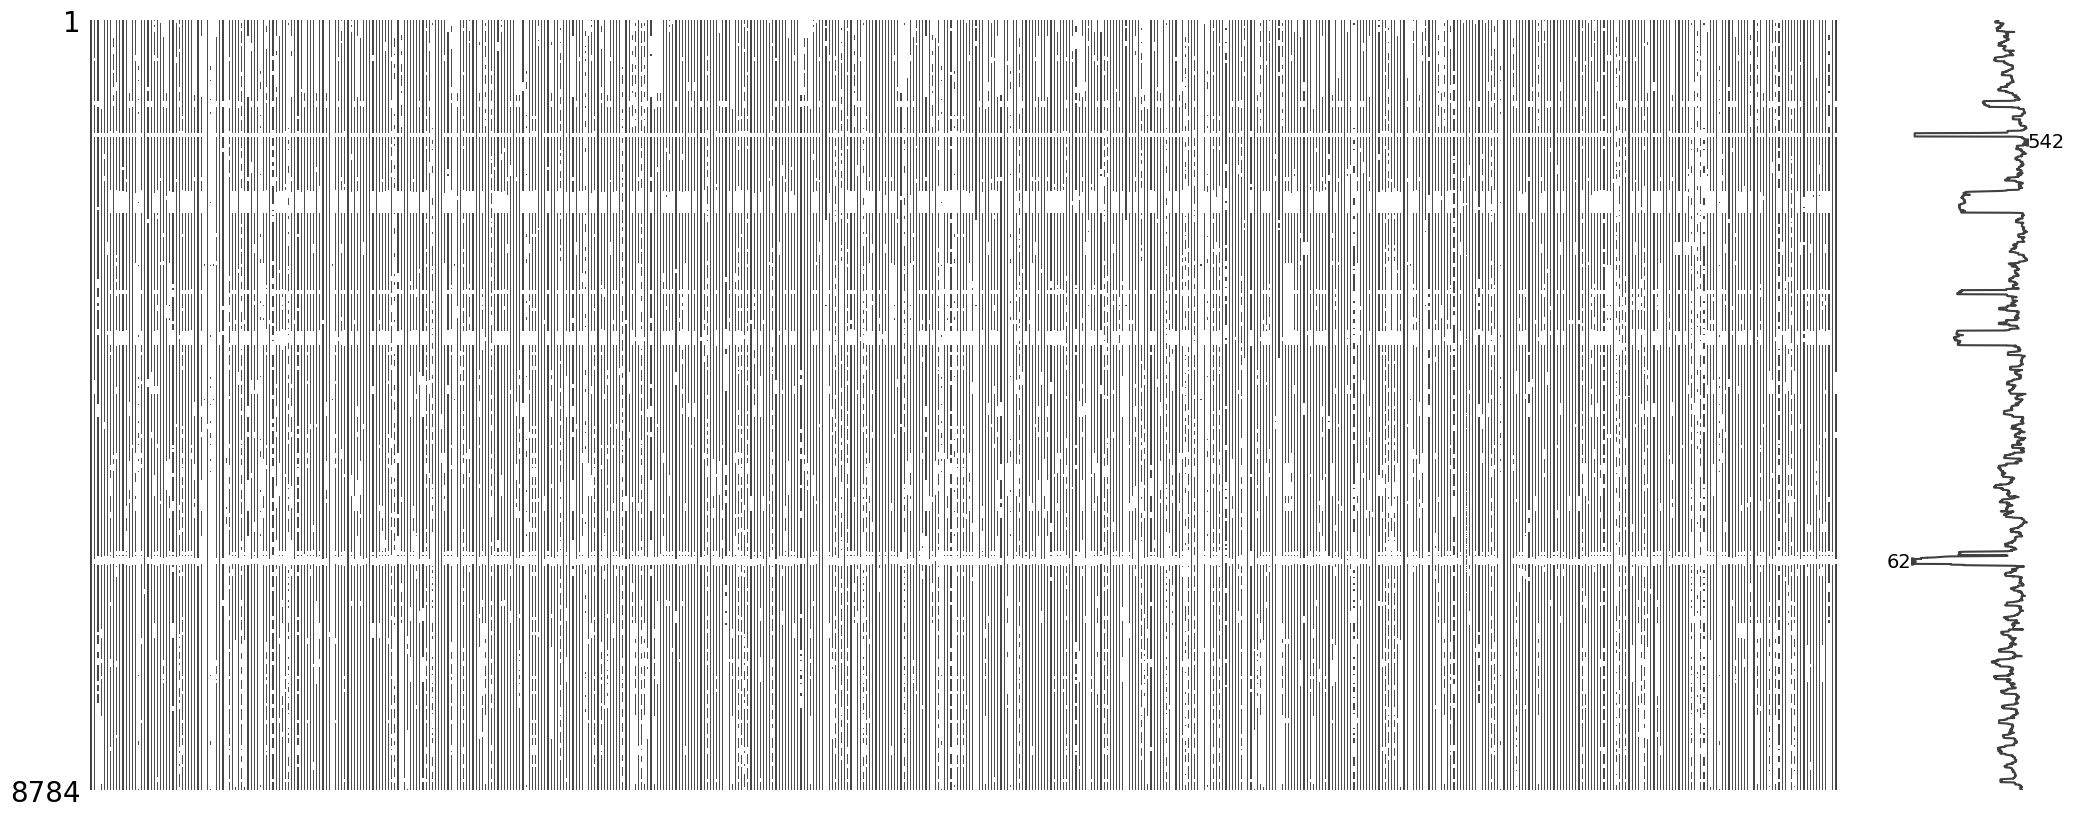

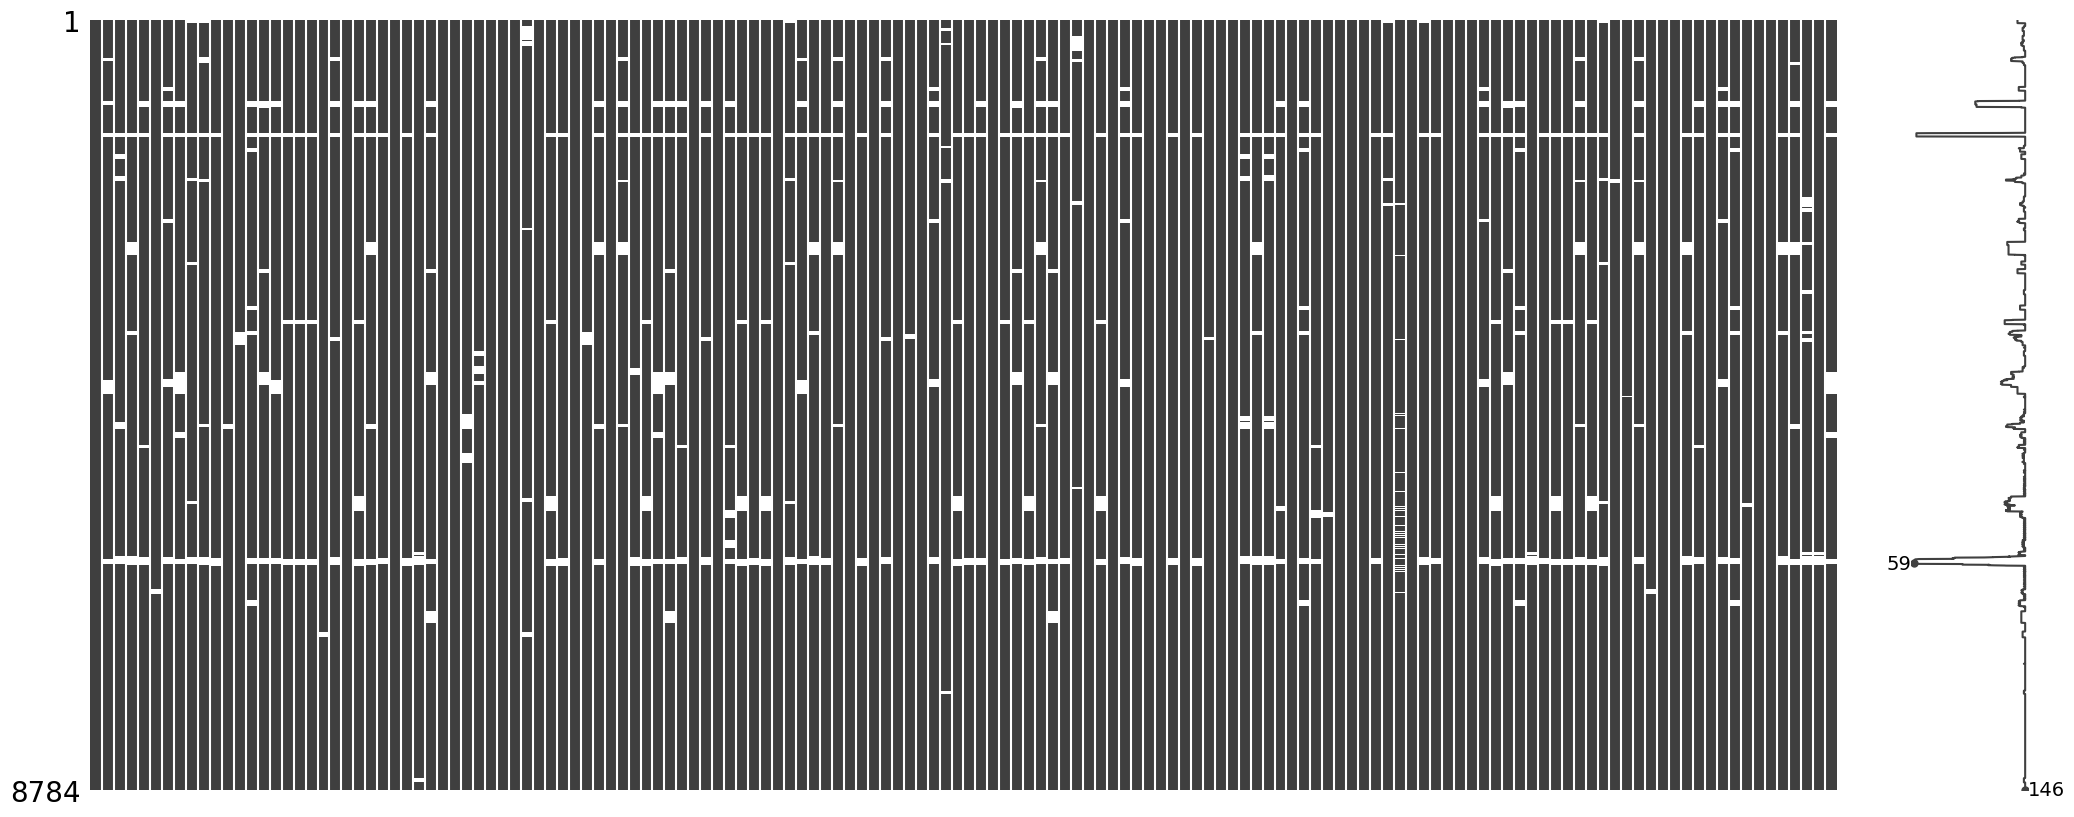

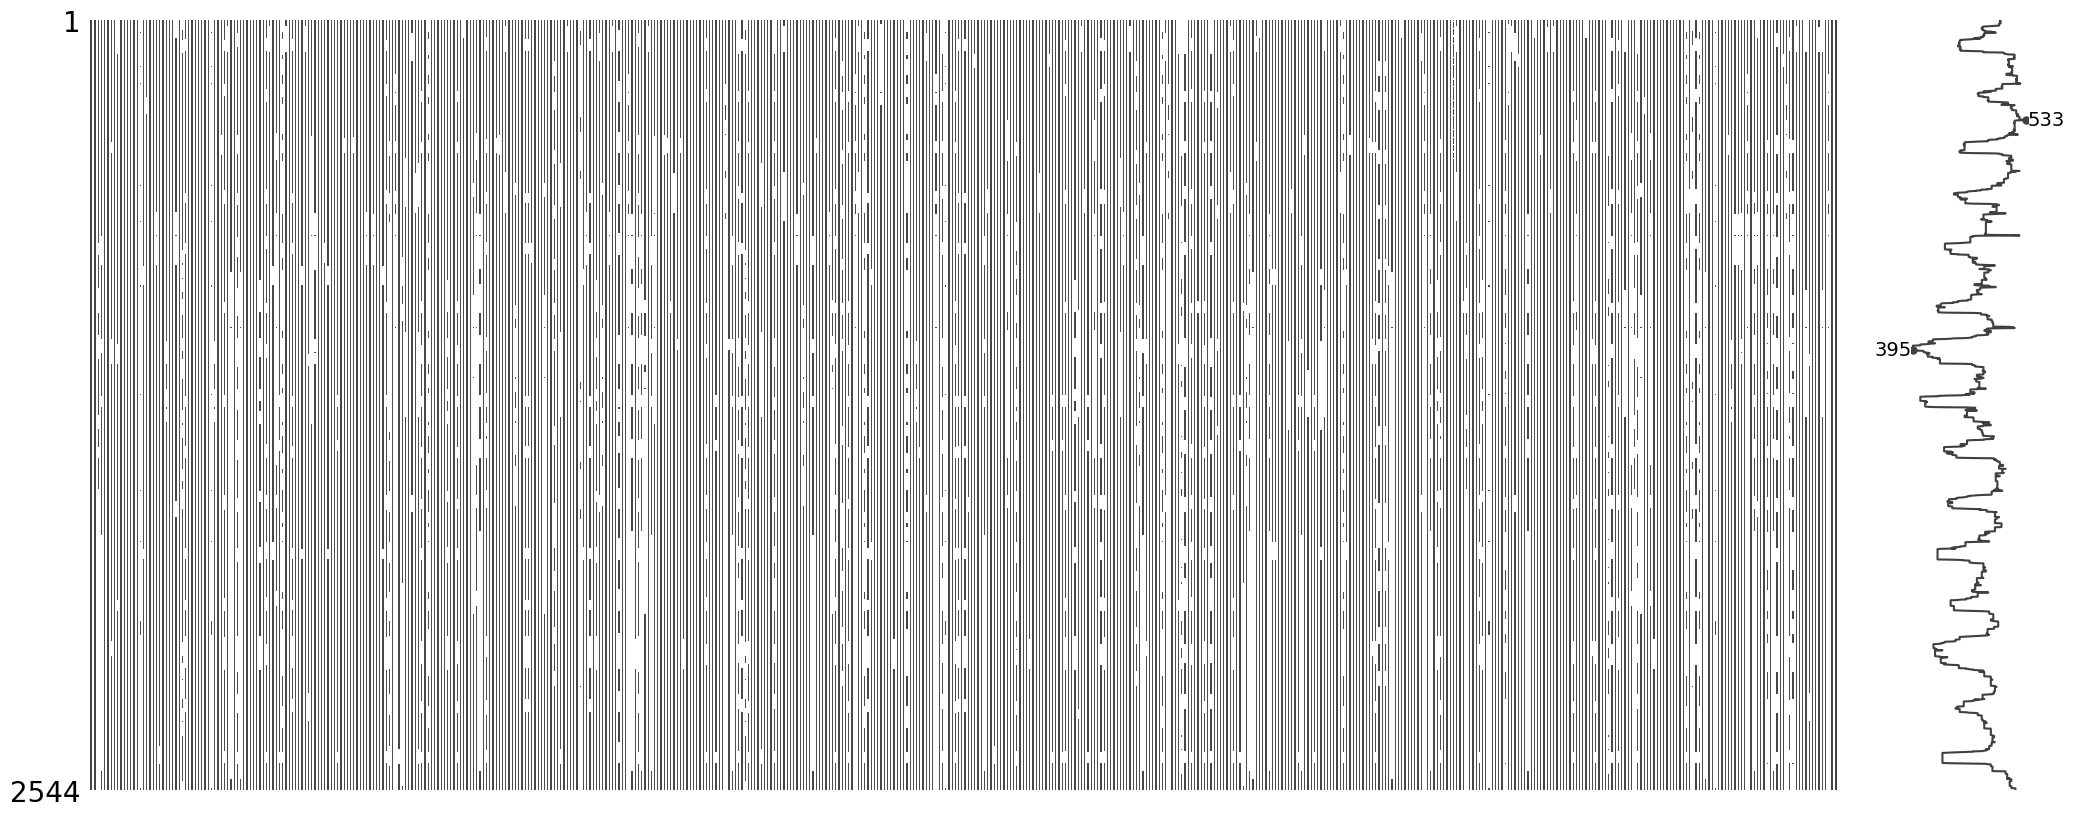

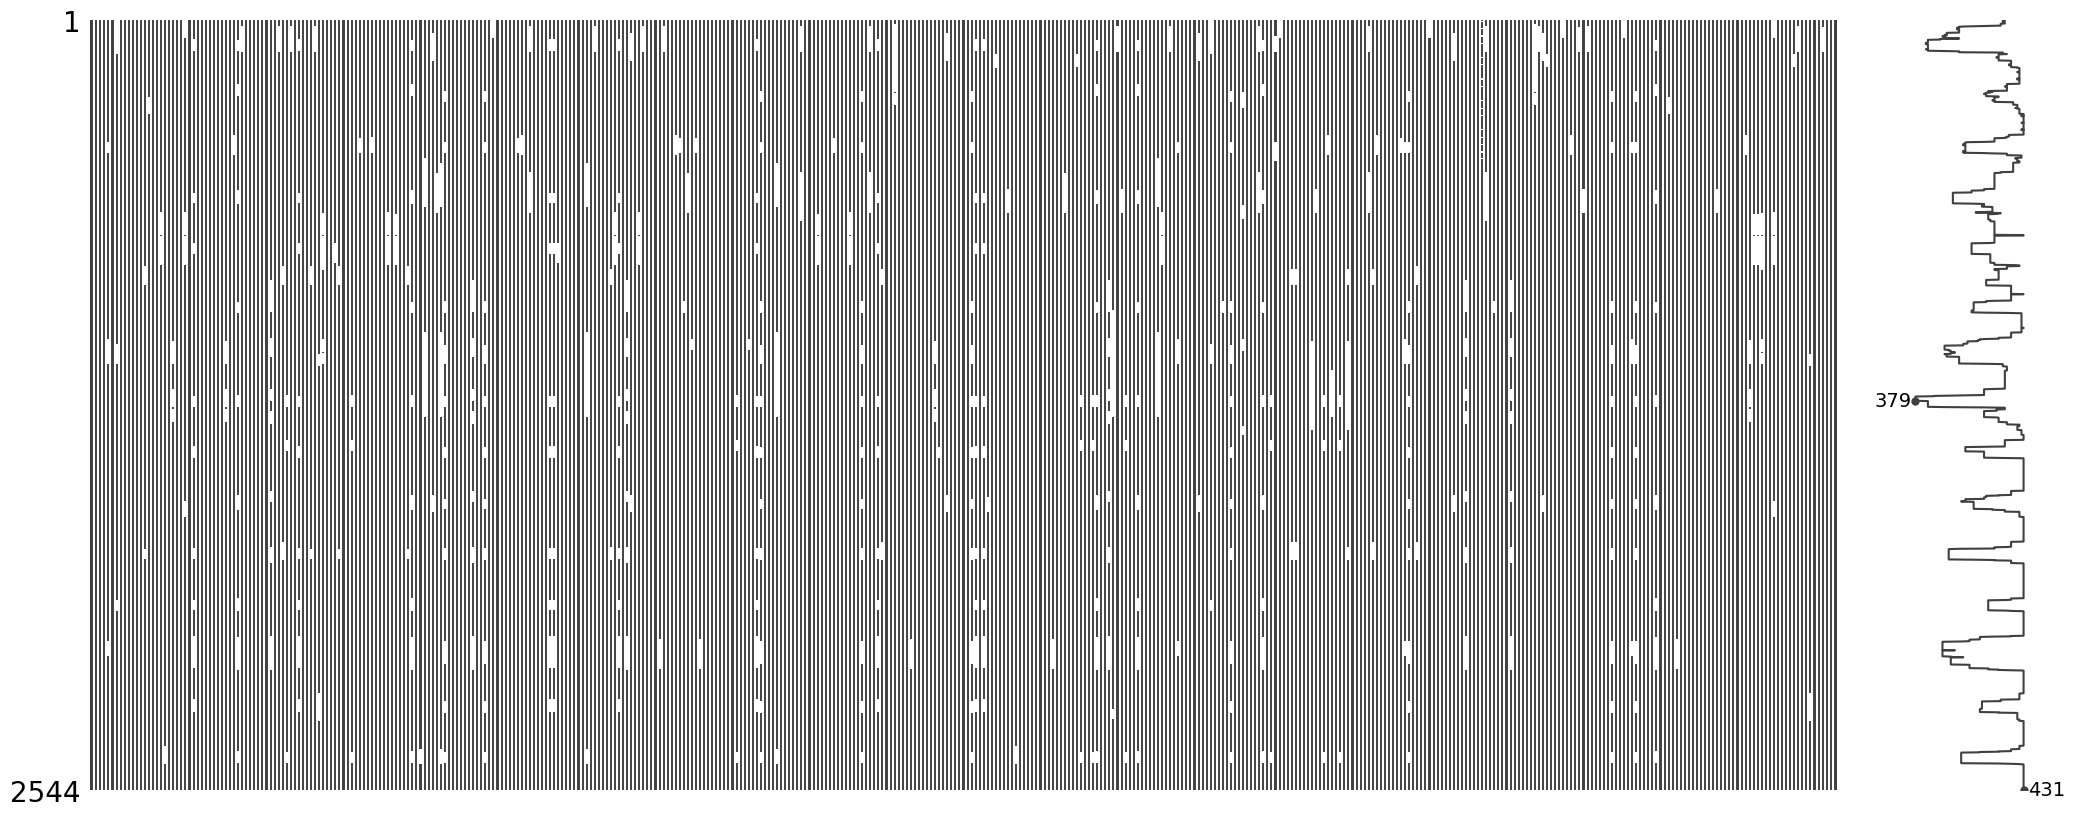

In [23]:
visualize_missing_matrix(traffic_data_cleaned_no_nan)
visualize_missing_matrix(traffic_data_cleaned_less500)
visualize_missing_matrix(traffic_data_cleaned_short_term)
visualize_missing_matrix(traffic_data_cleaned_combined)

In [24]:
def show_roads(roads_gdf: gpd.GeoDataFrame, color="red"):
    target: gpd.GeoDataFrame = yn_selected_roads[yn_selected_roads['sensor_id'].isin(roads_gdf.columns)]
    return target.explore(color=color, legend=True)

In [25]:
print(traffic_data_cleaned_no_nan.shape)
show_roads(traffic_data_cleaned_no_nan)

(8784, 559)


In [26]:
print(traffic_data_cleaned_less500.shape)
show_roads(traffic_data_cleaned_less500)

(8784, 146)


In [27]:
print(traffic_data_cleaned_short_term.shape)
show_roads(traffic_data_cleaned_short_term)

(2544, 540)


In [28]:
print(traffic_data_cleaned_combined.shape)
show_roads(traffic_data_cleaned_combined)

(2544, 431)


데이터셋 생성

In [29]:
import os

SUBSET_ROOT = "../datasets/metr-imc/subsets"
METR_1_ROOT = os.path.join(SUBSET_ROOT, "metr-1-cleaned")
METR_2_ROOT = os.path.join(SUBSET_ROOT, "metr-2-less500")
METR_3_ROOT = os.path.join(SUBSET_ROOT, "metr-3-short-term")
METR_4_ROOT = os.path.join(SUBSET_ROOT, "metr-4-combined")

os.makedirs(METR_1_ROOT, exist_ok=True)
os.makedirs(METR_2_ROOT, exist_ok=True)
os.makedirs(METR_3_ROOT, exist_ok=True)
os.makedirs(METR_4_ROOT, exist_ok=True)

traffic_data_cleaned_no_nan.to_hdf(os.path.join(METR_1_ROOT, "metr-imc.h5"), key="data")
traffic_data_cleaned_less500.to_hdf(os.path.join(METR_2_ROOT, "metr-imc.h5"), key="data")
traffic_data_cleaned_short_term.to_hdf(os.path.join(METR_3_ROOT, "metr-imc.h5"), key="data")
traffic_data_cleaned_combined.to_hdf(os.path.join(METR_4_ROOT, "metr-imc.h5"), key="data")

In [30]:
road_data = gpd.read_file("../datasets/metr-imc/nodelink/imc_link.shp")
turn_info = gpd.read_file("../datasets/metr-imc/nodelink/imc_turninfo.dbf")

In [31]:
interpolator = TimeMeanFillInterpolator()

In [32]:
def generate(
    root_path: str,
    interpolator: Interpolator,
    target_traffic_data: pd.DataFrame,
    columns: List[str] = None,
):
    generator = MetrImcSubsetGenerator(
        nodelink_dir="../datasets/metr-imc/nodelink",
        imcrts_dir="../datasets/metr-imc/imcrts",
        metr_imc_dir="../datasets/metr-imc/",
        turninfo_gdf_filename="imc_turninfo.dbf",
    )
    
    generator.metr_imc_df = target_traffic_data
    columns = target_traffic_data.columns.to_list() if columns is None else columns
    generator.generate_subset(
        targets=columns, output_dir=root_path, interpolate_filter=interpolator
    )

    pd.read_hdf(os.path.join(root_path, "metr-imc.h5")).to_excel(
        os.path.join(root_path, "metr-imc.xlsx")
    )

    SUBSET_TARGET_DISTANCE_FILE_PATH = os.path.join(root_path, "distances_imc_2023.csv")
    SUBSET_TARGET_SENSOR_FILE_PATH = os.path.join(
        root_path, "graph_sensor_locations.csv"
    )
    SUBSET_TARGET_NETWORK_DIR = os.path.join(root_path, "miscellaneous")

    print("Generating Sensor Network View...")
    SensorNetworkView(
        SUBSET_TARGET_DISTANCE_FILE_PATH,
        SUBSET_TARGET_SENSOR_FILE_PATH,
    ).to_file(SUBSET_TARGET_NETWORK_DIR)

In [33]:
generate(METR_1_ROOT, interpolator, traffic_data_cleaned_no_nan)

2024/08/21 10:32:56 metr.dataset.metr_imc.generator [INFO] Start generating subset...
2024/08/21 10:32:56 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-1-cleaned\metr-imc.h5 with (8784, 559) [Length: 559]...
2024/08/21 10:32:56 metr.dataset.metr_imc.generator [INFO] Interpolating...
2024/08/21 10:33:22 metr.dataset.metr_imc.generator [INFO] Interpolating Finished!
2024/08/21 10:33:22 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-1-cleaned\metr_ids.txt...
2024/08/21 10:33:22 metr.dataset.metr_imc.converter.metr_ids [INFO] Saving METR-IMC IDs to ../datasets/metr-imc/subsets\metr-1-cleaned\metr_ids.txt...
2024/08/21 10:33:22 metr.dataset.metr_imc.converter.metr_ids [INFO] Complete
2024/08/21 10:33:22 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-1-cleaned\graph_sensor_locations.csv...
2024/08/21 10:33:25 metr.dataset.metr_imc.converter.graph_sensor_locations [INFO] Saving sens

Generating Sensor Network View...


100%|██████████| 295055/295055 [00:09<00:00, 29737.29it/s]
2024/08/21 10:34:57 pyogrio._io [INFO] Created 559 records
2024/08/21 10:35:02 pyogrio._io [INFO] Created 294,496 records


In [34]:
generate(METR_2_ROOT, interpolator, traffic_data_cleaned_less500)

2024/08/21 10:35:05 metr.dataset.metr_imc.generator [INFO] Start generating subset...
2024/08/21 10:35:05 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-2-less500\metr-imc.h5 with (8784, 146) [Length: 146]...
2024/08/21 10:35:05 metr.dataset.metr_imc.generator [INFO] Interpolating...
2024/08/21 10:35:11 metr.dataset.metr_imc.generator [INFO] Interpolating Finished!
2024/08/21 10:35:11 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-2-less500\metr_ids.txt...
2024/08/21 10:35:11 metr.dataset.metr_imc.converter.metr_ids [INFO] Saving METR-IMC IDs to ../datasets/metr-imc/subsets\metr-2-less500\metr_ids.txt...
2024/08/21 10:35:11 metr.dataset.metr_imc.converter.metr_ids [INFO] Complete
2024/08/21 10:35:11 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-2-less500\graph_sensor_locations.csv...
2024/08/21 10:35:14 metr.dataset.metr_imc.converter.graph_sensor_locations [INFO] Saving sens

Generating Sensor Network View...


100%|██████████| 19765/19765 [00:00<00:00, 31000.95it/s]
2024/08/21 10:35:36 pyogrio._io [INFO] Created 146 records
2024/08/21 10:35:37 pyogrio._io [INFO] Created 19,619 records


In [35]:
generate(METR_3_ROOT, interpolator, traffic_data_cleaned_short_term)

2024/08/21 10:35:40 metr.dataset.metr_imc.generator [INFO] Start generating subset...
2024/08/21 10:35:40 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-3-short-term\metr-imc.h5 with (2544, 540) [Length: 540]...
2024/08/21 10:35:40 metr.dataset.metr_imc.generator [INFO] Interpolating...
2024/08/21 10:35:51 metr.dataset.metr_imc.generator [INFO] Interpolating Finished!
2024/08/21 10:35:51 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-3-short-term\metr_ids.txt...
2024/08/21 10:35:51 metr.dataset.metr_imc.converter.metr_ids [INFO] Saving METR-IMC IDs to ../datasets/metr-imc/subsets\metr-3-short-term\metr_ids.txt...
2024/08/21 10:35:51 metr.dataset.metr_imc.converter.metr_ids [INFO] Complete
2024/08/21 10:35:51 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-3-short-term\graph_sensor_locations.csv...
2024/08/21 10:35:54 metr.dataset.metr_imc.converter.graph_sensor_locations [INFO]

Generating Sensor Network View...


100%|██████████| 278140/278140 [00:09<00:00, 30765.49it/s]
2024/08/21 10:36:40 pyogrio._io [INFO] Created 540 records
2024/08/21 10:36:44 pyogrio._io [INFO] Created 277,600 records


In [36]:
generate(METR_4_ROOT, interpolator, traffic_data_cleaned_combined)

2024/08/21 10:36:47 metr.dataset.metr_imc.generator [INFO] Start generating subset...
2024/08/21 10:36:47 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-4-combined\metr-imc.h5 with (2544, 431) [Length: 431]...
2024/08/21 10:36:47 metr.dataset.metr_imc.generator [INFO] Interpolating...
2024/08/21 10:36:56 metr.dataset.metr_imc.generator [INFO] Interpolating Finished!
2024/08/21 10:36:56 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-4-combined\metr_ids.txt...
2024/08/21 10:36:56 metr.dataset.metr_imc.converter.metr_ids [INFO] Saving METR-IMC IDs to ../datasets/metr-imc/subsets\metr-4-combined\metr_ids.txt...
2024/08/21 10:36:56 metr.dataset.metr_imc.converter.metr_ids [INFO] Complete
2024/08/21 10:36:56 metr.dataset.metr_imc.generator [INFO] Generating ../datasets/metr-imc/subsets\metr-4-combined\graph_sensor_locations.csv...
2024/08/21 10:36:59 metr.dataset.metr_imc.converter.graph_sensor_locations [INFO] Saving 

Generating Sensor Network View...


100%|██████████| 179335/179335 [00:05<00:00, 30814.25it/s]
2024/08/21 10:37:33 pyogrio._io [INFO] Created 431 records
2024/08/21 10:37:36 pyogrio._io [INFO] Created 178,904 records


In [37]:
# # 1
# generator.metr_imc_df = traffic_data_cleaned
# columns = traffic_data_cleaned.columns.to_list()

# generator.generate_subset(columns, METR_1_ROOT, interpolator)

# pd.read_hdf(os.path.join(METR_1_ROOT, "metr-imc.h5")).to_excel(
#     os.path.join(METR_1_ROOT, "metr-imc.xlsx")
# )

# SUBSET_TARGET_DISTANCE_FILE_PATH = os.path.join(METR_1_ROOT, "distances_imc_2023.csv")
# SUBSET_TARGET_SENSOR_FILE_PATH = os.path.join(METR_1_ROOT, "graph_sensor_locations.csv")
# SUBSET_TARGET_NETWORK_DIR = os.path.join(METR_1_ROOT, "miscellaneous")

# SensorNetworkView(SUBSET_TARGET_DISTANCE_FILE_PATH, SUBSET_TARGET_SENSOR_FILE_PATH).to_file(SUBSET_TARGET_NETWORK_DIR)

In [38]:
# # 2
# generator.metr_imc_df = traffic_data_cleaned_less500
# columns = less_500_missing_columns

# generator.generate_subset(columns, METR_1_ROOT, interpolator)

# pd.read_hdf(os.path.join(METR_1_ROOT, "metr-imc.h5")).to_excel(
#     os.path.join(METR_1_ROOT, "metr-imc.xlsx")
# )

# SUBSET_TARGET_DISTANCE_FILE_PATH = os.path.join(METR_1_ROOT, "distances_imc_2023.csv")
# SUBSET_TARGET_SENSOR_FILE_PATH = os.path.join(METR_1_ROOT, "graph_sensor_locations.csv")
# SUBSET_TARGET_NETWORK_DIR = os.path.join(METR_1_ROOT, "miscellaneous")

# SensorNetworkView(SUBSET_TARGET_DISTANCE_FILE_PATH, SUBSET_TARGET_SENSOR_FILE_PATH).to_file(SUBSET_TARGET_NETWORK_DIR)